# Media Memorability Prediction

## About the Project

[*Predicting Media Memorability*](http://www.multimediaeval.org/mediaeval2018/memorability/index.html) task is proposed as part of the [*MediaEval 2018 Benchmarking Initiative for Multimedia Evaluation*](http://www.multimediaeval.org/mediaeval2018). The purpose of this task is the automatic prediction of multimedia content memorability. Understanding what makes a content memorable has a very broad range of current applications. Efficient memorability prediction models will also push forward the semantic understanding of multimedia content, by putting human perceptions through memorability in the center of the scene understanding.

For the task, participants will be provided with extensive datasets of multimedia content associated with memorability annotations, and with pre-extracted state-of-the-art audio-visual features. The corresponding ground truth consists of objective measures of memory performance and had been collected through recognition tests. Participants will be required to train computational models capable to infer multimedia content memorability from features of their choice. Models will be evaluated through standard evaluation metrics.

## License

Distributed under the *GNU General Public License*. See `LICENSE` for more information.

## Contact

***GitHub***: https://github.com/czs108

***E-Mail***: chenzs108@outlook.com

***WeChat***: chenzs108

## Dependences

- [*scikit-learn*](https://scikit-learn.org/stable)
- [*pandas*](https://pandas.pydata.org)
- [*Matplotlib*](https://matplotlib.org)
- [*NumPy*](https://numpy.org)

In [1]:
from typing import TYPE_CHECKING
from pathlib import Path, PurePath
from enum import Enum, auto
from functools import singledispatch
import re

from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

import pandas as pd
import numpy as np

if TYPE_CHECKING:
    from sklearn.base import Predictor
    from sklearn.pipeline import Pipeline
    from collections.abc import Callable, Sequence

## Dataset

The full development set consists of *8000* videos, together with their corresponding *short-term* and *long-term* memorability scores.

### Videos

Videos were extracted from raw footage used by professionals when creating content. They are varied and contain different scenes types. All videos are released in `.webm` format, with a bit rate of *3000 kbps*. They are provided as individual files, named:

```
video<Nb>.webm
```

`<Nb>` is the number of a video.

In [2]:
"""
Paths
"""
# The data path.
data_dir = Path("data")
# The training path.
dev_dir = data_dir.joinpath("dev-set")
# The test path.
test_dir = data_dir.joinpath("test-set")

# The extraction path.
extract_dir = Path("extract")
if not extract_dir.exists():
    extract_dir.mkdir()

# The statistic path.
stats_dir = Path("stats")
if not stats_dir.exists():
    stats_dir.mkdir()

## Evaluation

The official evaluation metric will be the *Spearman*'s rank correlation between the predicted memorability scores and the ground-truth memorability scores computed over all test videos.

In [3]:
# Short-term and long-term.
class Term(Enum):
    SHORT = auto()
    LONG= auto()

class Score:
    @staticmethod
    def calc(true: np.ndarray, pred: np.ndarray) -> float:
        """
        Calculate the Spearman's correlation coefficient.

        -- PARAMETERS --
        true: The true values.
        pred: The prediction values.

        -- RETURNS --
        The Spearman's correlation coefficient.
        """
        pred = np.squeeze(pred)
        true = np.squeeze(true)
        res = pd.DataFrame({"true": true, "pred": pred})
        score_mat = res[["true", "pred"]].corr(method="spearman", min_periods=1)
        return score_mat.iloc[1][0]

    @singledispatch
    def display(score: float | int | np.ndarray | list, term: Term) -> None:
        assert False, "Invalid Type"

    @display.register(float)
    @display.register(int)
    def _(score: float | int, term: Term) -> None:
        """
        Display a Spearman's correlation coefficient.

        -- PARAMETERS --
        score: A Spearman's correlation coefficient.
        term: Short-term or long-term.
        """
        print(f"The Spearman's correlation coefficient for {term.name}-term is: {round(score, 3)}")

    @display.register(list)
    def _(scores: list, term: Term) -> None:
        Score.display(np.array(scores), term)

    @display.register(np.ndarray)
    def _(scores: np.ndarray, term: Term) -> None:
        """
        Display the mean and standard deviation of an array of Spearman's correlation coefficients.

        -- PARAMETERS --
        scores: An array of correlation coefficients.
        term: Short-term or long-term.
        """
        print(f"The Spearman's correlation coefficient for {term.name}-term:")
        print(f"Mean: {round(scores.mean(), 3)}")
        print(f"Standard Deviation: {round(scores.std(), 3)}")

Create a scorer callable with the [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) method for cross-validation.

In [4]:
# Create a scorer callable for cross-validation.
scorer = make_scorer(Score.calc)

Only consider the following models in the project:

- *Linear Regression*
- *K-Nearest Neighbors Regression*
- *Support Vector Regression*
- *Random Forest Regression*
- *AdaBoost Regression*

In [5]:
"""
Model Names
"""
# Linear Regression
LN = "Linear"
# K-Nearest Neighbors Regression
KNN = "K-Nearest"
# Support Vector Regression
SV = "Support Vector"
# Random Forest Regression
RF = "Random Forest"
# AdaBoost Regression
AB = "AdaBoost"

Use two [`DataFrame`]("https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html") to save all tests' scores.

In [6]:
class ScoreStats:
    def __init__(self, short_csv: str, long_csv: str) -> None:
        """
        Load or create new score dataframes.
        """
        self._short_path: Path = stats_dir.joinpath(short_csv)
        self._long_path: Path = stats_dir.joinpath(long_csv)

        # Use two datadrames to save all tests' scores.
        if self._short_path.exists():
            self.short: pd.DataFrame = pd.read_csv(self._short_path).set_index(["feature", "score"])
        else:
            self.short: pd.DataFrame = pd.DataFrame(columns=[LN, KNN, SV, RF, AB], index=pd.MultiIndex.from_product([[], []], names=["feature", "score"]))
        if self._long_path.exists():
            self.long: pd.DataFrame = pd.read_csv(self._long_path).set_index(["feature", "score"])
        else:
            self.long: pd.DataFrame = pd.DataFrame(columns=[LN, KNN, SV, RF, AB], index=pd.MultiIndex.from_product([[], []], names=["feature", "score"]))

    def __getitem__(self, term: Term):
        return self.short if term == Term.SHORT else self.long

    def save(self) -> None:
        """
        Save scores to `.csv` files.
        """
        self.short.to_csv(self._short_path)
        self.long.to_csv(self._long_path)

In [7]:
score_stats = ScoreStats("short_scores.csv", "long_scores.csv")

### Loading Ground Truth

The corresponding ground truth for the development set can be found in the file `dev-set/ground-truth.csv`. It contains one line per video, which consists of:

- The video's name.
- Its *short-term* memorability score.
- The number of annotations that was used to calculate the *short-term* memorability score.
- Its *long-term* memorability score.
- The number of annotations that was used to calculate the *long-term* memorability score.

Example:

```
video10.webm, 0.950, 34, 0.900, 10
```

In [8]:
grd_truth = pd.read_csv(dev_dir.joinpath("ground-truth.csv"))

grd_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


## Data Preprocessing

In [9]:
class Identify:
    @staticmethod
    def id(filename: PurePath) -> int:
        """
        Get the video's ID from a feature file's name.
        """
        return int(re.search("video([0-9]+)", filename.stem).group(1))

    @staticmethod
    def frame(filename: PurePath) -> int:
        """
        Get the frame number from a feature file's name.
        """
        ret = re.search("video[0-9]+-([0-9]+)", filename.stem)
        return int(ret.group(1)) if ret else -1

Reorder the ground truth by the video's ID and delete unnecessary columns.

In [10]:
grd_truth["id"] = grd_truth["video"].apply(lambda x: Identify.id(PurePath(x)))
grd_truth.set_index("id", inplace=True)
grd_truth.drop(labels=["nb_short-term_annotations","nb_long-term_annotations"], axis="columns", inplace=True)
grd_truth.sort_values(by="id", inplace=True)

grd_truth.head()

,video,short-term_memorability,long-term_memorability
id,,,
3,video3.webm,0.924,0.846
4,video4.webm,0.923,0.667
6,video6.webm,0.863,0.700
8,video8.webm,0.922,0.818
10,video10.webm,0.950,0.900


In [11]:
grd_truth[["short-term_memorability", "long-term_memorability"]].describe()

,short-term_memorability,long-term_memorability
count,6000.000000,6000.000000
mean,0.860243,0.778941
std,0.080655,0.144692
min,0.388000,0.000000
25%,0.811000,0.700000
50%,0.867000,0.800000
75%,0.923000,0.900000
max,0.989000,1.000000


<AxesSubplot:title={'center':'The Density of Memorability for the Development Set'}, ylabel='Density'>

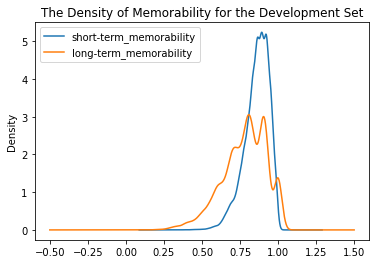

In [12]:
grd_truth[["short-term_memorability", "long-term_memorability"]].plot.kde(title="The Density of Memorability for the Development Set")

In [13]:
short_y = grd_truth[["short-term_memorability"]]
long_y = grd_truth[["long-term_memorability"]]

assert (short_y.index == long_y.index).all()
short_y.head()

,short-term_memorability
id,
3,0.924
4,0.923
6,0.863
8,0.922
10,0.950


### Feature Loaders

A set of pre-extracted visual features are provided to the participants to the task. Precomputed features are organized in different folders, one per feature.

This project only uses three features to train models. For the following two features, there is only one file for each video.

- *C3D*

  |    Item     | Description                                                  |
  | :---------: | :----------------------------------------------------------- |
  |   Outputs   | The final classification layer of the *3D Convolutional Neural Networks*. |
  | File Format | `.txt` file.                                                 |
  |   Feature   | A single list of numbers on one line, the dimension is *101*. |

- *HMP*

  |    Item     | Description                                                  |
  | :---------: | :----------------------------------------------------------- |
  |   Outputs   | *Histogram of Motion Patterns*.                              |
  | File Format | `.txt` file.                                                 |
  |   Feature   | A single list of pairs of numbers with format `bin:number` on one line, the dimension is *6075*. |

The next feature was extracted on three key-frames, the *first* (*0*), *one-third* (*56*) and *two-thirds* (*112*), on each video. So there are three files for each video, with names `video<Nb>-0.txt`, `video<Nb>-56.txt` and `video<Nb>-112.txt`.

- *LBP*

  |    Item     | Description                                                  |
  | :---------: | :----------------------------------------------------------- |
  |   Outputs   | *Local Binary Patterns*, calculated for patches of *8* × *15* pixels. |
  | File Format | `.txt` file.                                                 |
  |   Feature   | A single list of numbers on one line, the dimension depends on the image size. |

In [14]:
"""
Feature Names
"""
# 3D Convolutional Neural Network
C3D = "C3D"
# Histogram of Motion Patterns
HMP = "HMP"
# Local Binary Patterns
LBP = "LBP"

"""
Feature Lengths
"""
HMP_LEN = 6075
C3D_LEN = 101
LBP_LEN = 122 # 122 is the largest LBP dimension in the training set.

In [15]:
class Read:
    """
    Read features from a single sample.
    """
    @staticmethod
    def hmp(filename: Path) -> np.ndarray:
        """
        Read the Histogram of Motion Patterns (HMP) feature from a file.
        """
        with filename.open() as file:
            data = file.read()
            pairs = data.split()
            idx_hmp = {int(p.split(':')[0]): float(p.split(':')[1]) for p in pairs}
        # There are 6075 bins, fill zeros.
        hmp = np.zeros(HMP_LEN)
        for idx in idx_hmp.keys():
            hmp[idx - 1] = idx_hmp[idx]
        return hmp

    @staticmethod
    def c3d(filename: Path) -> np.ndarray:
        """
        Read the C3D feature from a file.
        It's the final classification layer of the 3D Convolutional Neural Network.
        """
        with filename.open() as file:
            data = file.read()
            c3d = [float(item) for item in data.split()]
        return np.pad(np.array(c3d), (0, C3D_LEN - len(c3d)), "constant")

    @staticmethod
    def lbp(filename: Path) -> np.ndarray:
        """
        Read the Local Binary Patterns (LBP) feature from a file.
        """
        with filename.open() as file:
            data = file.read()
            lbp = [float(item) for item in data.split()]
        return np.pad(np.array(lbp), (0, LBP_LEN - len(lbp)), "constant")

In [16]:
class Load:
    """
    Load features from all samples.
    """
    @staticmethod
    def hmp(index: Sequence[str], folder: Path) -> pd.DataFrame:
        """
        Load all videos' HMP features as a dataframe from a directory.
        """
        columns = [str(i) for i in range(HMP_LEN)]
        df = pd.DataFrame(columns=columns, index=index)

        def setter(name: PurePath) -> None:
            df.at[Identify.id(name), :] = Read.hmp(name)

        for name in folder.glob("*.txt"):
            setter(name)
        return df

    @staticmethod
    def c3d(index: Sequence[str], folder: Path) -> pd.DataFrame:
        """
        Load all videos' C3D features as a dataframe from a directory.
        """
        columns = [str(i) for i in range(C3D_LEN)]
        df = pd.DataFrame(columns=columns, index=index)

        def setter(name: PurePath) -> None:
            df.at[Identify.id(name), :] = Read.c3d(name)

        for name in folder.glob("*.txt"):
            setter(name)
        return df

    @staticmethod
    def lbp(index: Sequence[str], folder: Path) -> pd.DataFrame:
        """
        Load all videos' LBP features as a dataframe from a directory.

        -- NOTES --
        For each video, combine data from 3 frames as a single feature.
        """
        cols_1 = [str(i) for i in range(LBP_LEN)]
        cols_2 = [str(i) for i in range(LBP_LEN, LBP_LEN * 2)]
        cols_3 = [str(i) for i in range(LBP_LEN * 2, LBP_LEN * 3)]
        cols_map = {0: cols_1, 56: cols_2, 112: cols_3}

        df = pd.DataFrame(columns=cols_1 + cols_2 + cols_3, index=index)

        def setter(name: PurePath) -> None:
            id = Identify.id(name)
            frame = Identify.frame(name)
            cols = cols_map[frame]
            df.at[id, cols] = Read.lbp(name)

        for name in folder.glob("*.txt"):
            setter(name)
        return df

### Loading Features

After each feature has been initially loaded from its directory, the table will be saved in a `.csv` file for faster loading next time.

In [17]:
if TYPE_CHECKING:
    Loader = Callable[[Sequence[str], Path], pd.DataFrame]

def load_feature(index: Sequence[str], csv: Path, folder: Path, loader: Loader) -> pd.DataFrame:
    """
    Load features from a `.csv` file or a directory.

    -- PARAMETERS --
    index: An index.

    csv: A `.csv` file.
        If it exists, the method will directly load it and return.
        If it does not exist, the method will create it to save features.

    folder: A directory.
        If the `.csv` file does not exist,
        the method will load features from this directory with the help of `loader` callback.

    loader: A callback used to load features from a directory.

    -- RETURNS --
    A feature dataframe.
    """
    if csv.exists():
        return pd.read_csv(csv).set_index("id")
    else:
        df = loader(index, folder).sort_values(by="id")
        # Save the feature in a `.csv` file.
        df.to_csv(csv)
        return df

#### C3D

In [18]:
c3d = load_feature(grd_truth.index, extract_dir.joinpath(f"dev-{C3D}.csv"), dev_dir.joinpath(C3D), Load.c3d)
assert (c3d.index == grd_truth.index).all()
c3d.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
id,,,,,,,,,,,,,,,,,,,,,
3,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,...,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
4,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,...,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
6,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,...,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
8,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,...,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
10,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,...,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323


#### HMP

In [19]:
hmp = load_feature(grd_truth.index, extract_dir.joinpath(f"dev-{HMP}.csv"), dev_dir.joinpath(HMP), Load.hmp)
assert (hmp.index == grd_truth.index).all()
hmp.head()

,0,1,2,3,4,5,6,7,8,9,...,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
id,,,,,,,,,,,,,,,,,,,,,
3,0.125563,0.024036,0.000314,0.0,0.015864,0.000358,0.0,0.000000,0.000086,0.0,...,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
4,0.007526,0.001421,0.000068,0.0,0.001184,0.000143,0.0,0.000000,0.000079,0.0,...,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
6,0.109584,0.018978,0.000289,0.0,0.008774,0.000208,0.0,0.000002,0.000088,0.0,...,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
8,0.120431,0.013561,0.000277,0.0,0.018974,0.000913,0.0,0.000024,0.000713,0.0,...,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
10,0.005026,0.001356,0.000055,0.0,0.000665,0.000029,0.0,0.000000,0.000024,0.0,...,0.000009,0.000882,0.000200,0.000009,0.000559,0.001097,0.000018,0.000632,0.001128,0.000064


#### LBP

*LBP* features were extracted from three frames for each video. Combine them as a single long vector:

\begin{equation}
\bigl[v_{0}^{0},\, v_{1}^{0},\, \cdots,\, v_{121}^{0},\, v_{0}^{56},\, v_{1}^{56},\, \cdots,\, v_{121}^{56},\, v_{0}^{112},\, v_{1}^{112},\, \cdots,\, v_{121}^{112}\bigr]
\end{equation}

Where $v_{i}^{j}$ is the $i$th feature from the $j$th frame.

In [20]:
lbp = load_feature(grd_truth.index, extract_dir.joinpath(f"dev-{LBP}.csv"), dev_dir.joinpath(LBP), Load.lbp)
assert (lbp.index.unique(level="id") == grd_truth.index).all()
lbp.head()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
id,,,,,,,,,,,,,,,,,,,,,
3,0.011832,0.002344,0.001827,0.001400,0.002978,0.001540,0.001206,0.001338,0.001135,0.002456,...,0.003662,0.006215,0.006339,0.006231,0.008805,0.009746,0.008074,0.004699,0.135541,0.514539
4,0.009664,0.002918,0.002194,0.001868,0.002558,0.002044,0.001905,0.001840,0.001749,0.001888,...,0.001843,0.002144,0.002100,0.002151,0.002319,0.002662,0.002464,0.001534,0.020534,0.461064
6,0.010840,0.001895,0.001541,0.000961,0.002857,0.001182,0.000741,0.000833,0.000578,0.001172,...,0.002285,0.003928,0.003798,0.003482,0.004864,0.004392,0.003166,0.002012,0.123364,0.482255
8,0.011634,0.004315,0.003213,0.001912,0.002423,0.001428,0.001103,0.001135,0.000999,0.001311,...,0.003601,0.006800,0.006328,0.007033,0.011622,0.011662,0.009279,0.005855,0.224420,0.535760
10,0.025250,0.004858,0.004892,0.003862,0.004429,0.003433,0.003179,0.003398,0.003172,0.003559,...,0.002474,0.002568,0.002568,0.002832,0.003209,0.004080,0.004773,0.003983,0.026907,0.688721


## Cross-Validation

Use the [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) method to evaluate a score by cross-validation.

In [21]:
if TYPE_CHECKING:
    Matrix = pd.DataFrame | np.ndarray

# The models that need target values to be an array-like of shape (n,).
ravel_mods = set([SV, RF, AB])

def cv_train_model(feature: str, model: str, pred: Predictor | Pipeline, term: Term, X: Matrix, record: bool = True) -> np.ndarray:
    """
    Train a model by cross-validation and record its score.

    -- PARAMETERS --
    feature: The feature name.
    model: The model name.
    regr: A regressor.
    term: Short-term or long-term.
    X: Features.
    record: Whether to record scores.

    -- RETURNS --
    An array of scores.
    """
    y = short_y if term == Term.SHORT else long_y
    if model in ravel_mods:
        y = y.values.ravel()
    scores = cross_val_score(pred, X, y, scoring=scorer)
    if record:
        score_stats[term].at[(feature, "mean"), model] = round(scores.mean(), 3)
        score_stats[term].at[(feature, "std"), model] = round(scores.std(), 3)
    Score.display(scores, term)
    return scores

## Experiments with Single Feature

### C3D

#### Linear Regression

In [22]:
cv_train_model(C3D, LN, LinearRegression(), Term.SHORT, c3d)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.276
Standard Deviation: 0.016


(LinearRegression(),
 array([0.28429877, 0.24728574, 0.2930274 , 0.28121191, 0.27339381]))

In [23]:
cv_train_model(C3D, LN, LinearRegression(), Term.LONG, c3d)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.114
Standard Deviation: 0.019


(LinearRegression(),
 array([0.1466378 , 0.10286209, 0.12110697, 0.09092741, 0.10620066]))

#### K-Nearest Neighbors Regression

In [24]:
cv_train_model(C3D, KNN, KNeighborsRegressor(), Term.SHORT, c3d)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.183
Standard Deviation: 0.019


(KNeighborsRegressor(),
 array([0.17472603, 0.21671059, 0.17439766, 0.18851039, 0.15971126]))

In [25]:
cv_train_model(C3D, KNN, KNeighborsRegressor(), Term.LONG, c3d)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.064
Standard Deviation: 0.027


(KNeighborsRegressor(),
 array([0.11362562, 0.03253811, 0.06425305, 0.06587593, 0.04617649]))

#### Support Vector Regression

In [26]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(C3D, SV, pipeline, Term.SHORT, c3d)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.248
Standard Deviation: 0.026


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.21860103, 0.22389799, 0.26141646, 0.28985545, 0.24819164]))

In [27]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(C3D, SV, pipeline, Term.LONG, c3d)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.093
Standard Deviation: 0.016


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.11195604, 0.08255464, 0.11297046, 0.07385585, 0.08353294]))

#### Random Forest Regression

In [28]:
cv_train_model(C3D, RF, RandomForestRegressor(), Term.SHORT, c3d)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.304
Standard Deviation: 0.018


(RandomForestRegressor(),
 array([0.31548405, 0.26845678, 0.31493865, 0.31393541, 0.30842949]))

In [29]:
cv_train_model(C3D, RF, RandomForestRegressor(), Term.LONG, c3d)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.13
Standard Deviation: 0.015


(RandomForestRegressor(),
 array([0.10349963, 0.12690984, 0.13210923, 0.14110524, 0.14595573]))

#### AdaBoost Regression

In [30]:
cv_train_model(C3D, AB, AdaBoostRegressor(), Term.SHORT, c3d)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.257
Standard Deviation: 0.012


(AdaBoostRegressor(),
 array([0.26378354, 0.24774166, 0.26595594, 0.23791798, 0.26892053]))

In [31]:
cv_train_model(C3D, AB, AdaBoostRegressor(), Term.LONG, c3d)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.113
Standard Deviation: 0.009


(AdaBoostRegressor(),
 array([0.11104418, 0.09950819, 0.12850089, 0.11319594, 0.11376926]))

In [32]:
score_stats.save()

### HMP

#### Linear Regression

In [33]:
cv_train_model(HMP, LN, LinearRegression(), Term.SHORT, hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: -0.007
Standard Deviation: 0.03


(LinearRegression(),
 array([-0.03164443,  0.00664516,  0.03488494, -0.04963696,  0.00701348]))

In [34]:
cv_train_model(HMP, LN, LinearRegression(), Term.LONG, hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: -0.008
Standard Deviation: 0.029


(LinearRegression(),
 array([-0.03721559,  0.01833991, -0.04835154,  0.0158657 ,  0.01097076]))

#### K-Nearest Neighbors Regression

In [35]:
cv_train_model(HMP, KNN, KNeighborsRegressor(), Term.SHORT, hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.199
Standard Deviation: 0.01


(KNeighborsRegressor(),
 array([0.20698307, 0.201871  , 0.18199439, 0.20940392, 0.19460417]))

In [36]:
cv_train_model(HMP, KNN, KNeighborsRegressor(), Term.LONG, hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.06
Standard Deviation: 0.031


(KNeighborsRegressor(),
 array([0.07675827, 0.01586802, 0.05606419, 0.04442495, 0.10885185]))

#### Support Vector Regression

In [37]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(HMP, SV, pipeline, Term.SHORT, hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.278
Standard Deviation: 0.022


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.2956044 , 0.29102198, 0.24808447, 0.30054735, 0.25698931]))

In [38]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(HMP, SV, pipeline, Term.LONG, hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.111
Standard Deviation: 0.025


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.09417085, 0.07777513, 0.12706539, 0.10549387, 0.14924148]))

#### Random Forest Regression

In [39]:
cv_train_model(HMP, RF, RandomForestRegressor(), Term.SHORT, hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.295
Standard Deviation: 0.007


(RandomForestRegressor(),
 array([0.29613258, 0.28711641, 0.30503674, 0.29880543, 0.28665615]))

In [40]:
cv_train_model(HMP, RF, RandomForestRegressor(), Term.LONG, hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.114
Standard Deviation: 0.014


(RandomForestRegressor(),
 array([0.09951099, 0.11134102, 0.12089548, 0.09989099, 0.13817083]))

#### AdaBoost Regression

In [41]:
cv_train_model(HMP, AB, AdaBoostRegressor(), Term.SHORT, hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.244
Standard Deviation: 0.016


(AdaBoostRegressor(),
 array([0.23820071, 0.21473612, 0.25618285, 0.25106176, 0.25745714]))

In [42]:
cv_train_model(HMP, AB, AdaBoostRegressor(), Term.LONG, hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.079
Standard Deviation: 0.024


(AdaBoostRegressor(),
 array([0.04937874, 0.06553024, 0.11942125, 0.07101382, 0.08965824]))

In [43]:
score_stats.save()

#### Using Principal Component Analysis to Reduce Dimensions

The number of *HMP* features is larger than the number of samples, try to remove some features with [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), remaining *1000* features.

In [44]:
pca = PCA(n_components=1000)
pca_hmp = pca.fit_transform(hmp)

pca.explained_variance_ratio_.sum()

0.9999323531245211

Then train several models on principal features for *short-term*.

In [45]:
hmp_means = pd.DataFrame(columns=[LN, KNN, SV, RF, AB])
hmp_means.loc["raw", :] = score_stats[Term.SHORT].loc[(HMP, "mean"), :]

In [46]:
scores = cv_train_model(HMP, LN, LinearRegression(), Term.SHORT, pca_hmp, False)
hmp_means.at["pca", LN] = round(scores.mean(), 3)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.238
Standard Deviation: 0.01


In [47]:
scores = cv_train_model(HMP, KNN, KNeighborsRegressor(), Term.SHORT, pca_hmp, False)
hmp_means.at["pca", KNN] = round(scores.mean(), 3)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.199
Standard Deviation: 0.01


In [48]:
pipeline = make_pipeline(StandardScaler(), SVR())
scores = cv_train_model(HMP, SV, pipeline, Term.SHORT, pca_hmp, False)
hmp_means.at["pca", SV] = round(scores.mean(), 3)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.183
Standard Deviation: 0.015


In [49]:
scores = cv_train_model(HMP, RF, RandomForestRegressor(), Term.SHORT, pca_hmp, False)
hmp_means.at["pca", RF] = round(scores.mean(), 3)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.218
Standard Deviation: 0.013


In [50]:
scores = cv_train_model(HMP, AB, AdaBoostRegressor(), Term.SHORT, pca_hmp, False)
hmp_means.at["pca", AB] = round(scores.mean(), 3)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.148
Standard Deviation: 0.017


*PCA* only provided a significant performance improvement for *Linear Regression*. For *K-Nearest Neighbors Regression*, it helped nothing. To make matters worse, PCA reduced the prediction effect of the other three models.

In [51]:
hmp_means

,Linear,K-Nearest,Support Vector,Random Forest,AdaBoost
raw,-0.007,0.199,0.278,0.295,0.244
pca,0.238,0.199,0.183,0.218,0.148


<AxesSubplot:title={'center':'Mean Scores for Short-term Prediction with HMP'}>

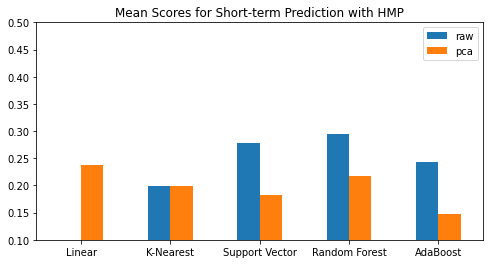

In [52]:
hmp_means.T.plot.bar(title=f"Mean Scores for Short-term Prediction with {HMP}", ylim=(0.1, 0.5), rot=0, figsize=(8, 4))

### LBP

#### Linear Regression

In [53]:
cv_train_model(LBP, LN, LinearRegression(), Term.SHORT, lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.181
Standard Deviation: 0.017


(LinearRegression(),
 array([0.19930193, 0.16895478, 0.19359405, 0.18726855, 0.15419126]))

In [54]:
cv_train_model(LBP, LN, LinearRegression(), Term.LONG, lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.057
Standard Deviation: 0.012


(LinearRegression(),
 array([0.071378  , 0.05677746, 0.03649458, 0.05692813, 0.06575205]))

#### K-Nearest Neighbors Regression

In [55]:
cv_train_model(LBP, KNN, KNeighborsRegressor(), Term.SHORT, lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.121
Standard Deviation: 0.03


(KNeighborsRegressor(),
 array([0.1215393 , 0.08876908, 0.15792504, 0.15174691, 0.08653417]))

In [56]:
cv_train_model(LBP, KNN, KNeighborsRegressor(), Term.LONG, lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.038
Standard Deviation: 0.017


(KNeighborsRegressor(),
 array([0.05529183, 0.03642678, 0.05843655, 0.01259276, 0.02673638]))

#### Support Vector Regression

In [57]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(LBP, SV, pipeline, Term.SHORT, lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.25
Standard Deviation: 0.026


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.25350096, 0.22582873, 0.28432102, 0.27171803, 0.21462141]))

In [58]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(LBP, SV, pipeline, Term.LONG, lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.078
Standard Deviation: 0.03


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.0877247 , 0.04728393, 0.13132232, 0.07343785, 0.05223418]))

#### Random Forest Regression

In [59]:
cv_train_model(LBP, RF, RandomForestRegressor(), Term.SHORT, lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.279
Standard Deviation: 0.025


(RandomForestRegressor(),
 array([0.3094874 , 0.25675979, 0.29282617, 0.29084536, 0.24343674]))

In [60]:
cv_train_model(LBP, RF, RandomForestRegressor(), Term.LONG, lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.107
Standard Deviation: 0.027


(RandomForestRegressor(),
 array([0.13427818, 0.10080016, 0.13678036, 0.09826947, 0.06494006]))

#### AdaBoost Regression

In [61]:
cv_train_model(LBP, AB, AdaBoostRegressor(), Term.SHORT, lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.19
Standard Deviation: 0.028


(AdaBoostRegressor(),
 array([0.22692249, 0.19166674, 0.15729033, 0.21541253, 0.15974062]))

In [62]:
cv_train_model(LBP, AB, AdaBoostRegressor(), Term.LONG, lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.066
Standard Deviation: 0.034


(AdaBoostRegressor(),
 array([0.08603602, 0.07732302, 0.10869486, 0.01134471, 0.04852789]))

In [63]:
score_stats.save()

### The Summary for Single Feature

In [64]:
idx = pd.IndexSlice

#### Short-term Prediction

<AxesSubplot:title={'center':'Mean Scores for Short-term Prediction with Single Feature'}, xlabel='feature'>

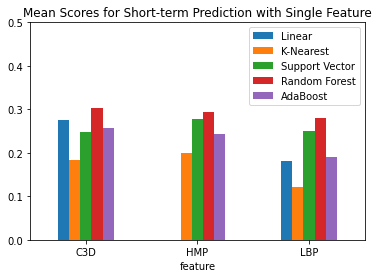

In [65]:
short_scores = score_stats[Term.SHORT].loc[idx[:, "mean"], :].droplevel("score").loc[[C3D, HMP, LBP], :]
short_scores.plot.bar(title="Mean Scores for Short-term Prediction with Single Feature", ylim=(0, 0.5), rot=0)

<AxesSubplot:title={'center':'Standard Deviations of Scores for Short-term Prediction with Single Feature'}, xlabel='feature'>

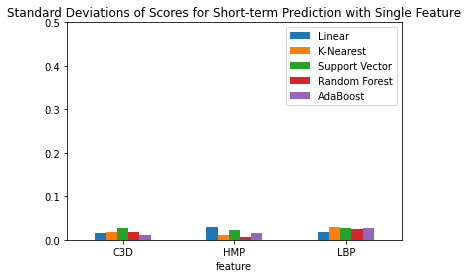

In [66]:
short_scores_std = score_stats[Term.SHORT].loc[idx[:, "std"], :].droplevel("score").loc[[C3D, HMP, LBP], :]
short_scores_std.plot.bar(title="Standard Deviations of Scores for Short-term Prediction with Single Feature", ylim=(0, 0.5), rot=0)

#### Long-term Prediction

<AxesSubplot:title={'center':'Mean Scores for Long-term Prediction with Single Feature'}, xlabel='feature'>

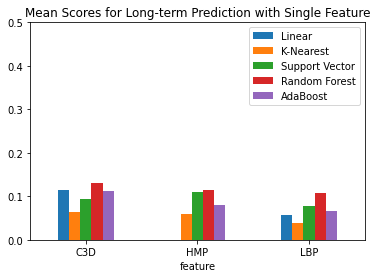

In [67]:
long_scores = score_stats[Term.LONG].loc[idx[:, "mean"], :].droplevel("score").loc[[C3D, HMP, LBP], :]
long_scores.plot.bar(title="Mean Scores for Long-term Prediction with Single Feature", ylim=(0, 0.5), rot=0)

<AxesSubplot:title={'center':'Standard Deviations of Scores for Long-term Prediction with Single Feature'}, xlabel='feature'>

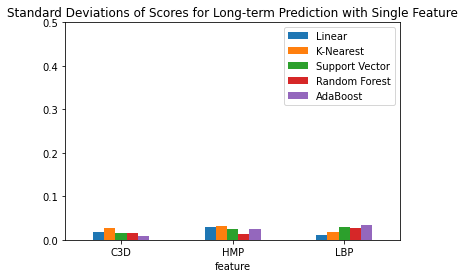

In [68]:
long_scores_std = score_stats[Term.LONG].loc[idx[:, "std"], :].droplevel("score").loc[[C3D, HMP, LBP], :]
long_scores_std.plot.bar(title="Standard Deviations of Scores for Long-term Prediction with Single Feature", ylim=(0, 0.5), rot=0)

## Experiments with Combined Features

### Combining C3D with LBP

In [69]:
C3D_LBP = f"{C3D} + {LBP}"

c3d_lbp = pd.concat([c3d, lbp], axis="columns")
c3d_lbp.shape

(6000, 467)

#### Linear Regression

In [70]:
cv_train_model(C3D_LBP, LN, LinearRegression(), Term.SHORT, c3d_lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.236
Standard Deviation: 0.016


(LinearRegression(),
 array([0.26038178, 0.22633661, 0.23351699, 0.24698541, 0.21336935]))

In [71]:
cv_train_model(C3D_LBP, LN, LinearRegression(), Term.LONG, c3d_lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.082
Standard Deviation: 0.015


(LinearRegression(),
 array([0.10055072, 0.08666227, 0.05350439, 0.08420816, 0.08285959]))

#### K-Nearest Neighbors Regression

In [72]:
pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor())
cv_train_model(C3D_LBP, KNN, pipeline, Term.SHORT, c3d_lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.219
Standard Deviation: 0.022


(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsregressor', KNeighborsRegressor())]),
 array([0.22824399, 0.17658848, 0.22001945, 0.23514478, 0.23255392]))

In [73]:
pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor())
cv_train_model(C3D_LBP, KNN, pipeline, Term.LONG, c3d_lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.033
Standard Deviation: 0.015


(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsregressor', KNeighborsRegressor())]),
 array([0.03067299, 0.00717722, 0.05176777, 0.030729  , 0.04275836]))

#### Support Vector Regression

In [74]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(C3D_LBP, SV, pipeline, Term.SHORT, c3d_lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.264
Standard Deviation: 0.029


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.28919507, 0.23567069, 0.27020339, 0.29952609, 0.22520898]))

In [75]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(C3D_LBP, SV, pipeline, Term.LONG, c3d_lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.094
Standard Deviation: 0.041


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.12115682, 0.06815371, 0.16152493, 0.04840749, 0.07041769]))

#### Random Forest Regression

In [76]:
cv_train_model(C3D_LBP, RF, RandomForestRegressor(), Term.SHORT, c3d_lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.316
Standard Deviation: 0.021


(RandomForestRegressor(),
 array([0.34419746, 0.29220786, 0.33134563, 0.32079081, 0.29309108]))

In [77]:
cv_train_model(C3D_LBP, RF, RandomForestRegressor(), Term.LONG, c3d_lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.144
Standard Deviation: 0.023


(RandomForestRegressor(),
 array([0.14992914, 0.13617923, 0.18510765, 0.1308762 , 0.11998597]))

#### AdaBoost Regression

In [78]:
cv_train_model(C3D_LBP, AB, AdaBoostRegressor(), Term.SHORT, c3d_lbp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.26
Standard Deviation: 0.013


(AdaBoostRegressor(),
 array([0.27785572, 0.24124319, 0.25656546, 0.25410424, 0.27108756]))

In [79]:
cv_train_model(C3D_LBP, AB, AdaBoostRegressor(), Term.LONG, c3d_lbp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.107
Standard Deviation: 0.018


(AdaBoostRegressor(),
 array([0.1253641 , 0.08998394, 0.1241136 , 0.08059427, 0.11475855]))

In [80]:
score_stats.save()

### Combining C3D with HMP

In [81]:
C3D_HMP = f"{C3D} + {HMP}"

c3d_hmp = pd.concat([c3d, hmp], axis="columns")
c3d_hmp.shape

(6000, 6176)

#### Linear Regression

In [82]:
cv_train_model(C3D_HMP, LN, LinearRegression(), Term.SHORT, c3d_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.007
Standard Deviation: 0.023


(LinearRegression(),
 array([-0.03681251,  0.00791229,  0.03210561,  0.01823191,  0.01239068]))

In [83]:
cv_train_model(C3D_HMP, LN, LinearRegression(), Term.LONG, c3d_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: -0.007
Standard Deviation: 0.032


(LinearRegression(),
 array([-0.03291512, -0.04893891, -0.00786063,  0.01324054,  0.03966713]))

#### K-Nearest Neighbors Regression

In [84]:
pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor())
cv_train_model(C3D_HMP, KNN, pipeline, Term.SHORT, c3d_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.199
Standard Deviation: 0.028


(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsregressor', KNeighborsRegressor())]),
 array([0.21398681, 0.15499483, 0.17730041, 0.22762491, 0.22229918]))

In [85]:
pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor())
cv_train_model(C3D_HMP, KNN, pipeline, Term.LONG, c3d_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.064
Standard Deviation: 0.013


(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsregressor', KNeighborsRegressor())]),
 array([0.05046421, 0.07751766, 0.04652119, 0.07224632, 0.07226793]))

#### Support Vector Regression

In [86]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(C3D_HMP, SV, pipeline, Term.SHORT, c3d_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.292
Standard Deviation: 0.02


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.30912377, 0.30517416, 0.26718943, 0.30911242, 0.26820882]))

In [87]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(C3D_HMP, SV, pipeline, Term.LONG, c3d_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.114
Standard Deviation: 0.021


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.10794426, 0.08849374, 0.11845986, 0.10380205, 0.15080691]))

#### Random Forest Regression

In [88]:
cv_train_model(C3D_HMP, RF, RandomForestRegressor(), Term.SHORT, c3d_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.334
Standard Deviation: 0.008


(RandomForestRegressor(),
 array([0.33115097, 0.3308327 , 0.33429792, 0.34823628, 0.32387588]))

In [89]:
cv_train_model(C3D_HMP, RF, RandomForestRegressor(), Term.LONG, c3d_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.133
Standard Deviation: 0.02


(RandomForestRegressor(),
 array([0.11342395, 0.13046951, 0.14726467, 0.11224864, 0.16291996]))

#### AdaBoost Regression

In [90]:
cv_train_model(C3D_HMP, AB, AdaBoostRegressor(), Term.SHORT, c3d_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.269
Standard Deviation: 0.015


(AdaBoostRegressor(),
 array([0.29494693, 0.26243597, 0.25462224, 0.27622002, 0.25915553]))

In [91]:
cv_train_model(C3D_HMP, AB, AdaBoostRegressor(), Term.LONG, c3d_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.09
Standard Deviation: 0.02


(AdaBoostRegressor(),
 array([0.06314846, 0.07966824, 0.12164238, 0.08299214, 0.10212648]))

In [92]:
score_stats.save()

### Combining LBP with HMP

In [93]:
LBP_HMP = f"{LBP} + {HMP}"

lbp_hmp = pd.concat([lbp, hmp], axis="columns")
lbp_hmp.shape

(6000, 6441)

#### Linear Regression

In [94]:
cv_train_model(LBP_HMP, LN, LinearRegression(), Term.SHORT, lbp_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: -0.007
Standard Deviation: 0.026


(LinearRegression(),
 array([ 0.01883923,  0.01095574,  0.0107493 , -0.03692269, -0.04087699]))

In [95]:
cv_train_model(LBP_HMP, LN, LinearRegression(), Term.LONG, lbp_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: -0.005
Standard Deviation: 0.027


(LinearRegression(),
 array([ 0.00281515,  0.01283537,  0.02140964, -0.05489063, -0.00848882]))

#### K-Nearest Neighbors Regression

In [96]:
pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor())
cv_train_model(LBP_HMP, KNN, pipeline, Term.SHORT, lbp_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.222
Standard Deviation: 0.022


(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsregressor', KNeighborsRegressor())]),
 array([0.22638117, 0.19481521, 0.20279712, 0.25536521, 0.23300493]))

In [97]:
pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor())
cv_train_model(LBP_HMP, KNN, pipeline, Term.LONG, lbp_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.044
Standard Deviation: 0.015


(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsregressor', KNeighborsRegressor())]),
 array([0.04851123, 0.03399041, 0.02014926, 0.05434482, 0.06065265]))

#### Support Vector Regression

In [98]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(LBP_HMP, SV, pipeline, Term.SHORT, lbp_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.29
Standard Deviation: 0.018


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.31500076, 0.2875023 , 0.27339231, 0.30572753, 0.26859232]))

In [99]:
pipeline = make_pipeline(StandardScaler(), SVR())
cv_train_model(LBP_HMP, SV, pipeline, Term.LONG, lbp_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.112
Standard Deviation: 0.029


(Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())]),
 array([0.09202775, 0.07366584, 0.13987735, 0.10467102, 0.1513153 ]))

#### Random Forest Regression

In [100]:
cv_train_model(LBP_HMP, RF, RandomForestRegressor(), Term.SHORT, lbp_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.325
Standard Deviation: 0.014


(RandomForestRegressor(),
 array([0.31954637, 0.31260434, 0.34052542, 0.34218808, 0.31076849]))

In [101]:
cv_train_model(LBP_HMP, RF, RandomForestRegressor(), Term.LONG, lbp_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.114
Standard Deviation: 0.032


(RandomForestRegressor(),
 array([0.07792983, 0.10177548, 0.16513934, 0.0893836 , 0.13402536]))

#### AdaBoost Regression

In [102]:
cv_train_model(LBP_HMP, AB, AdaBoostRegressor(), Term.SHORT, lbp_hmp)

The Spearman's correlation coefficient for SHORT-term:
Mean: 0.259
Standard Deviation: 0.008


(AdaBoostRegressor(),
 array([0.26145191, 0.24558372, 0.26167549, 0.26996035, 0.25612793]))

In [103]:
cv_train_model(LBP_HMP, AB, AdaBoostRegressor(), Term.LONG, lbp_hmp)

The Spearman's correlation coefficient for LONG-term:
Mean: 0.079
Standard Deviation: 0.035


(AdaBoostRegressor(),
 array([0.01709626, 0.12046151, 0.10046131, 0.07000814, 0.08677149]))

In [104]:
score_stats.save()

### The Summary for Combined Features

In [105]:
idx = pd.IndexSlice

#### Short-term Prediction

<AxesSubplot:title={'center':'Mean Scores for Short-term Prediction with Combined Features'}, xlabel='feature'>

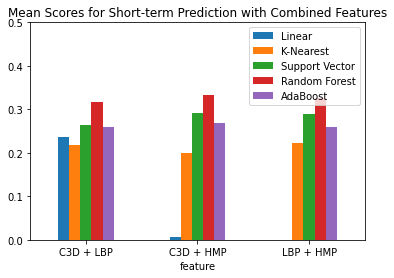

In [106]:
short_scores = score_stats[Term.SHORT].loc[idx[:, "mean"], :].droplevel("score").loc[[C3D_LBP, C3D_HMP, LBP_HMP], :]
short_scores.plot.bar(title="Mean Scores for Short-term Prediction with Combined Features", ylim=(0, 0.5), rot=0)

<AxesSubplot:title={'center':'Standard Deviations of Scores for Short-term Prediction with Combined Features'}, xlabel='feature'>

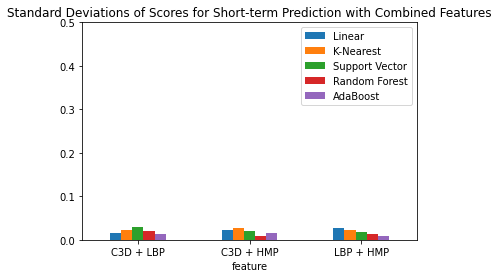

In [107]:
short_scores_std = score_stats[Term.SHORT].loc[idx[:, "std"], :].droplevel("score").loc[[C3D_LBP, C3D_HMP, LBP_HMP], :]
short_scores_std.plot.bar(title="Standard Deviations of Scores for Short-term Prediction with Combined Features", ylim=(0, 0.5), rot=0)

#### Long-term Prediction

<AxesSubplot:title={'center':'Mean Scores for Long-term Prediction with Combined Features'}, xlabel='feature'>

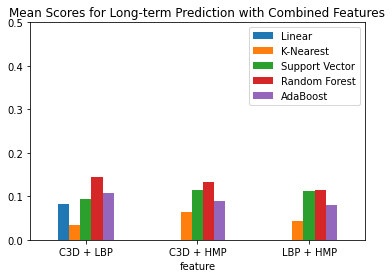

In [108]:
long_scores = score_stats[Term.LONG].loc[idx[:, "mean"], :].droplevel("score").loc[[C3D_LBP, C3D_HMP, LBP_HMP], :]
long_scores.plot.bar(title="Mean Scores for Long-term Prediction with Combined Features", ylim=(0, 0.5), rot=0)

<AxesSubplot:title={'center':'Standard Deviations of Scores for Long-term Prediction with Combined Features'}, xlabel='feature'>

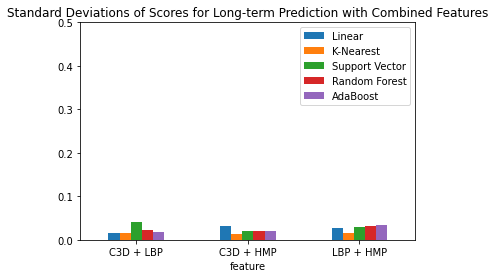

In [109]:
long_scores_std = score_stats[Term.LONG].loc[idx[:, "std"], :].droplevel("score").loc[[C3D_LBP, C3D_HMP, LBP_HMP], :]
long_scores_std.plot.bar(title="Standard Deviations of Scores for Long-term Prediction with Combined Features", ylim=(0, 0.5), rot=0)

## Choosing the Best Feature and Model

In [110]:
idx = pd.IndexSlice

In [111]:
def show_feature_importances(vals: Sequence[float], title: str) -> None:
    """
    Show feature importances.
    """
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(vals)), vals, align="center")
    plt.ylim([0, 0.03])
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title(title)
    plt.show()

### Short-term Prediction

In [112]:
short_scores = score_stats[Term.SHORT].loc[idx[:, "mean"], :].droplevel("score")
short_scores

,Linear,K-Nearest,Support Vector,Random Forest,AdaBoost
feature,,,,,
C3D,0.276,0.183,0.248,0.304,0.257
HMP,-0.007,0.199,0.278,0.295,0.244
LBP,0.181,0.121,0.250,0.279,0.190
C3D + LBP,0.236,0.219,0.264,0.316,0.260
C3D + HMP,0.007,0.199,0.292,0.334,0.269
LBP + HMP,-0.007,0.222,0.290,0.325,0.259


<AxesSubplot:title={'center':'Mean Scores for Short-term Prediction'}, xlabel='feature'>

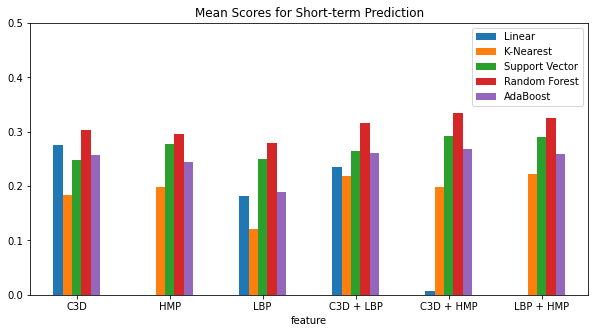

In [113]:
short_scores.plot.bar(title="Mean Scores for Short-term Prediction", ylim=(0, 0.5), rot=0, figsize=(10, 5))

<AxesSubplot:title={'center':'Standard Deviations of Scores for Short-term Prediction'}, xlabel='feature'>

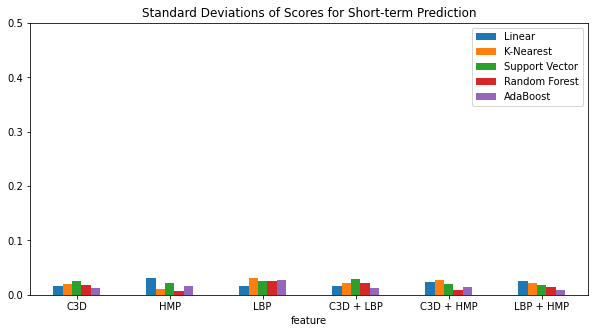

In [114]:
short_scores_std = score_stats[Term.SHORT].loc[idx[:, "std"], :].droplevel("score")
short_scores_std.plot.bar(title="Standard Deviations of Scores for Short-term Prediction", ylim=(0, 0.5), rot=0, figsize=(10, 5))

For *short-term* predictions, *C3D* + *HMP* with *Random Forest Regression* has the best performance. Its mean score and standard deviation of scores are:

In [115]:
score_stats[Term.SHORT].loc[C3D_HMP, RF]

score
mean    0.334
std     0.008
Name: Random Forest, dtype: float64

Train a new model with the full development set.

In [116]:
short_regr = RandomForestRegressor()
short_regr.fit(c3d_hmp, short_y.values.ravel())

RandomForestRegressor()

Show the importances for each feature.

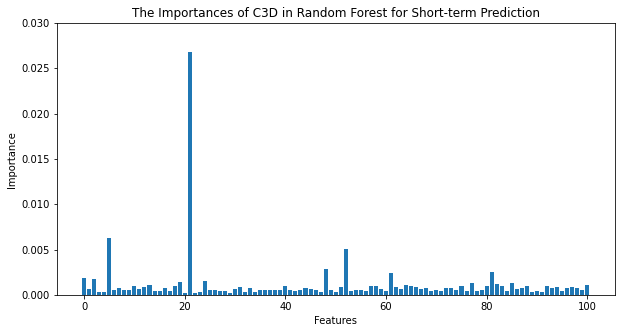

In [117]:
show_feature_importances(short_regr.feature_importances_[:C3D_LEN], "The Importances of C3D in Random Forest for Short-term Prediction")

It is clear that the *21st* dimension of *C3D* is absolutely the most important value for *short-term* predictions and *HMP* does not provide much help.

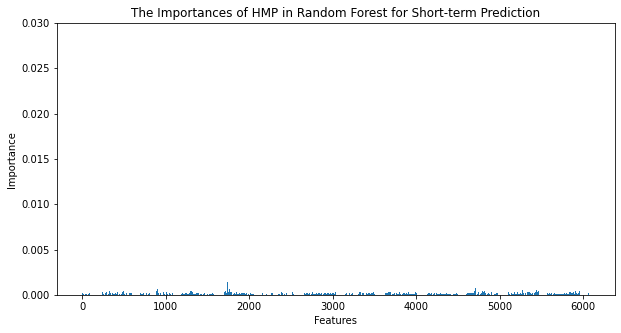

In [118]:
show_feature_importances(short_regr.feature_importances_[C3D_LEN:C3D_LEN + HMP_LEN], "The Importances of HMP in Random Forest for Short-term Prediction")

Create a dataframe both containing the *short-term* memorability and *21st* value of *C3D*.

In [119]:
short_mem_c3d = pd.concat([short_y, c3d["21"]], axis="columns").rename(columns={"21": "21st-C3D"})

short_mem_c3d.head()

,short-term_memorability,21st-C3D
id,,
3,0.924,0.000032
4,0.923,0.001153
6,0.863,0.002905
8,0.922,0.000027
10,0.950,0.007324


There is no obvious relation between these two variables.

<AxesSubplot:title={'center':'The Distribution of Short-term Memorability and the 21st C3D Value for the Development Set'}, xlabel='short-term_memorability', ylabel='21st-C3D'>

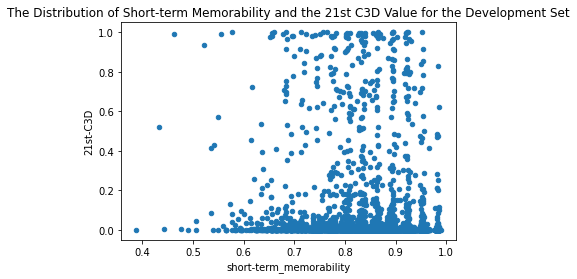

In [120]:
short_mem_c3d.plot.scatter(x="short-term_memorability", y="21st-C3D", title="The Distribution of Short-term Memorability and the 21st C3D Value for the Development Set")

### Long-term Prediction

In [121]:
long_scores = score_stats[Term.LONG].loc[idx[:, "mean"], :].droplevel("score")
long_scores

,Linear,K-Nearest,Support Vector,Random Forest,AdaBoost
feature,,,,,
C3D,0.114,0.064,0.093,0.130,0.113
HMP,-0.008,0.060,0.111,0.114,0.079
LBP,0.057,0.038,0.078,0.107,0.066
C3D + LBP,0.082,0.033,0.094,0.144,0.107
C3D + HMP,-0.007,0.064,0.114,0.133,0.090
LBP + HMP,-0.005,0.044,0.112,0.114,0.079


<AxesSubplot:title={'center':'Mean Scores for Long-term Prediction'}, xlabel='feature'>

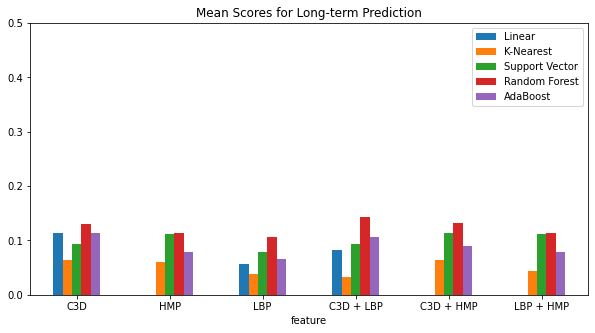

In [122]:
long_scores.plot.bar(title="Mean Scores for Long-term Prediction", ylim=(0, 0.5), rot=0, figsize=(10, 5))

<AxesSubplot:title={'center':'Standard Deviations of Scores for Long-term Prediction'}, xlabel='feature'>

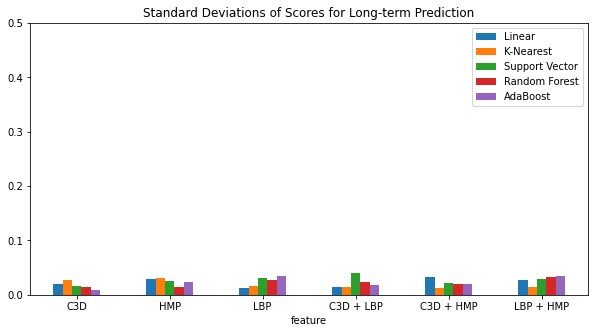

In [123]:
long_scores_std = score_stats[Term.LONG].loc[idx[:, "std"], :].droplevel("score")
long_scores_std.plot.bar(title="Standard Deviations of Scores for Long-term Prediction", ylim=(0, 0.5), rot=0, figsize=(10, 5))

For *long-term* predictions, *C3D* + *LBP* with *Random Forest Regression* is the best. Its mean score and standard deviation of scores are:

In [124]:
score_stats[Term.LONG].loc[C3D_LBP, RF]

score
mean    0.144
std     0.023
Name: Random Forest, dtype: float64

Train a new model with the full development set.

In [125]:
long_regr = RandomForestRegressor()
long_regr.fit(c3d_lbp, long_y.values.ravel())

RandomForestRegressor()

Show the importances for each feature.

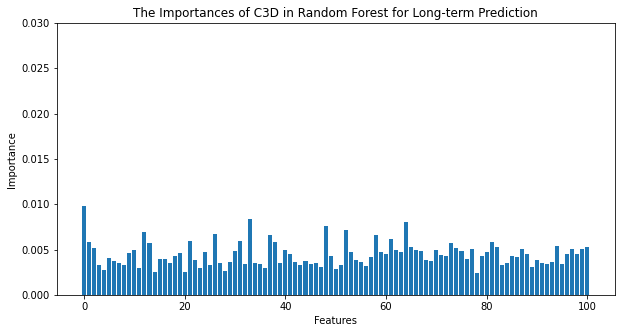

In [126]:
show_feature_importances(long_regr.feature_importances_[:C3D_LEN], "The Importances of C3D in Random Forest for Long-term Prediction")

Compared with *short-term*, the feature importances are more balanced in *long-term* predictions.

And for *LBP* feature, considering that a *LBP* vector is combined from three key-frames, we can see that for each frame, the values at the beginning, middle and end are more important than others.

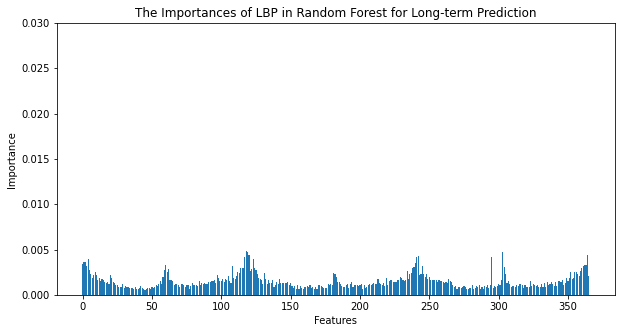

In [127]:
show_feature_importances(long_regr.feature_importances_[C3D_LEN:C3D_LEN + LBP_LEN * 3], "The Importances of LBP in Random Forest for Long-term Prediction")

Draw a heat map to show the *LBP* importances for a frame. The resolution would be different for each video.

The figure shows that the important parts are mainly located at the top, middle and bottom of a frame.

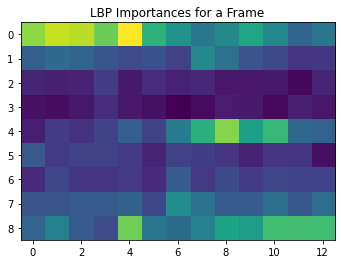

In [128]:
# The resolution would be different for each video.
ftr_imprtncs = long_regr.feature_importances_[C3D_LEN:C3D_LEN + 117]
plt.imshow(ftr_imprtncs.reshape((-1, 13)))  # The values of 117 and 13 may not be suitable for some videos.
plt.title("LBP Importances for a Frame")
plt.show()

Sort *long-term* memorability scores.

In [129]:
sorted_long_y = long_y.sort_values(by="long-term_memorability", ascending=False)
sorted_long_y

,long-term_memorability
id,
5390,1.000
5458,1.000
531,1.000
1556,1.000
1549,1.000
...,...
3000,0.231
6289,0.222
3280,0.200


Find the videos having the highest and lowest *long-term* memorability scores and show their *LBP* values of the first key-frame using heat maps.

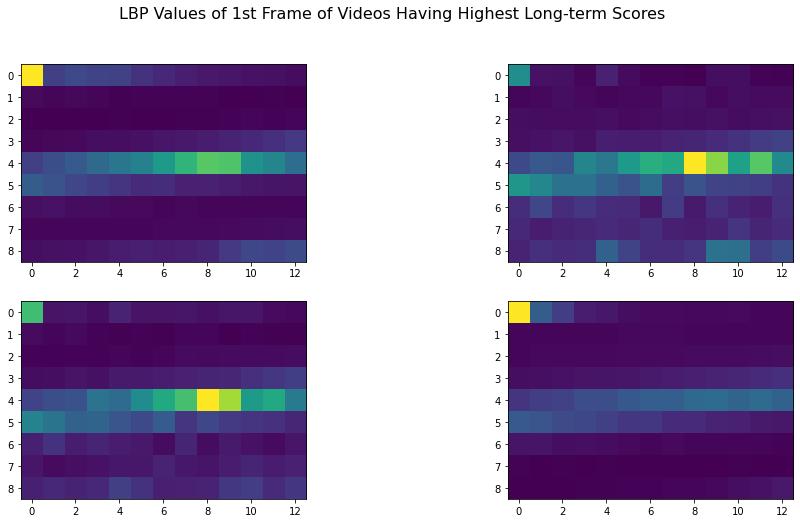

In [130]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ids = sorted_long_y.index[:4]
axs[0, 0].imshow(lbp.loc[ids[0]].values[:117].reshape((-1, 13)))
axs[0, 1].imshow(lbp.loc[ids[1]].values[:117].reshape((-1, 13)))
axs[1, 0].imshow(lbp.loc[ids[2]].values[:117].reshape((-1, 13)))
axs[1, 1].imshow(lbp.loc[ids[3]].values[:117].reshape((-1, 13)))

fig.suptitle("LBP Values of 1st Frame of Videos Having Highest Long-term Scores", fontsize=16)
plt.show()

Compared with the videos having the lowest memorability scores, it seems that the most memorable videos tend to have large *LBP* values at the middle of a frame.

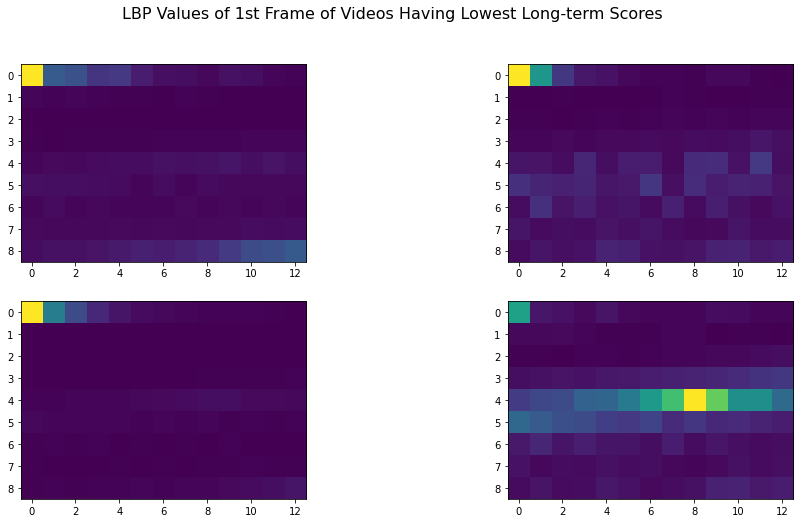

In [131]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ids = sorted_long_y.index[-4:]
axs[0, 0].imshow(lbp.loc[ids[0]].values[:117].reshape((-1, 13)))
axs[0, 1].imshow(lbp.loc[ids[1]].values[:117].reshape((-1, 13)))
axs[1, 0].imshow(lbp.loc[ids[2]].values[:117].reshape((-1, 13)))
axs[1, 1].imshow(lbp.loc[ids[3]].values[:117].reshape((-1, 13)))

fig.suptitle("LBP Values of 1st Frame of Videos Having Lowest Long-term Scores", fontsize=16)
plt.show()

## Predicting Test Samples

### Loading Ground Truth Template

Rename the name of `video` column to `id`.

In [132]:
pred_truth = pd.read_csv(test_dir.joinpath("ground-truth-template.csv")).rename(columns={"video": "id"}).set_index("id")

pred_truth.head()

,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
id,,,,
7494,NaN,33,NaN,12
7495,NaN,34,NaN,10
7496,NaN,32,NaN,13
7497,NaN,33,NaN,10
7498,NaN,33,NaN,10


### Loading Features

In [133]:
test_c3d = load_feature(pred_truth.index, extract_dir.joinpath(f"test-{C3D}.csv"), test_dir.joinpath(C3D), Load.c3d)
assert (test_c3d.index == pred_truth.index).all()
test_c3d.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
id,,,,,,,,,,,,,,,,,,,,,
7494,0.000136,0.000213,0.001248,0.000011,0.000001,0.000043,0.000001,0.000006,0.000007,0.00007,...,0.000003,0.000006,0.000001,0.000199,0.000002,0.0,0.000006,0.000006,0.00021,0.19512
7495,0.000127,0.000024,0.049501,0.000024,0.000024,0.000003,0.000051,0.000124,0.000023,0.000018,...,0.000173,0.000302,0.000265,0.000163,0.00001,0.000003,0.000362,0.000016,0.00001,0.000392
7496,0.488982,0.000585,0.000025,0.00016,0.0,0.000001,0.000004,0.000001,0.000027,0.000003,...,0.000002,0.0,0.0,0.001802,0.000003,0.0,0.0,0.000067,0.000123,0.000015
7497,0.249251,0.001018,0.000008,0.000019,0.0,0.000001,0.016466,0.000047,0.000025,0.000002,...,0.000065,0.000001,0.0,0.000808,0.000001,0.000008,0.000001,0.000015,0.000707,0.00001
7498,0.009894,0.000034,0.002613,0.000002,0.000001,0.000009,0.000003,0.0,0.000005,0.000088,...,0.000012,0.000001,0.000009,0.000132,0.000001,0.000002,0.000008,0.001402,0.000745,0.000456


In [134]:
test_hmp = load_feature(pred_truth.index, extract_dir.joinpath(f"test-{HMP}.csv"), test_dir.joinpath(HMP), Load.hmp)
assert (test_hmp.index == pred_truth.index).all()
test_hmp.head()

,0,1,2,3,4,5,6,7,8,9,...,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
id,,,,,,,,,,,,,,,,,,,,,
7494,0.022039,0.005264,0.000098,0.0,0.003689,0.000129,0.0,0.0,0.000045,0.0,...,0.000025,0.000114,0.000056,0.000002,0.000136,0.000388,0.000038,0.000165,0.000488,0.000187
7495,0.004694,0.001934,0.00004,0.0,0.001226,0.000058,0.0,0.0,0.000025,0.0,...,0.0,0.000056,0.000027,0.000002,0.000087,0.000121,0.000004,0.000109,0.000136,0.000029
7496,0.02653,0.006208,0.000058,0.0,0.00228,0.000031,0.0,0.0,0.000009,0.0,...,0.000011,0.000034,0.000011,0.000002,0.000063,0.000081,0.000004,0.000092,0.000143,0.000051
7497,0.045109,0.008317,0.000151,0.0,0.005598,0.000128,0.0,0.000008,0.00005,0.0,...,0.000035,0.000256,0.000083,0.000003,0.000116,0.000467,0.00002,0.000279,0.00047,0.000219
7498,0.034691,0.008619,0.000412,0.0,0.028355,0.000538,0.0,0.0,0.000325,0.0,...,0.000009,0.000148,0.000038,0.000002,0.000117,0.000206,0.000022,0.000228,0.000334,0.000086


In [135]:
test_lbp = load_feature(pred_truth.index, extract_dir.joinpath(f"test-{LBP}.csv"), test_dir.joinpath(LBP), Load.lbp)
assert (test_lbp.index == pred_truth.index).all()
test_lbp.head()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
id,,,,,,,,,,,,,,,,,,,,,
7494,0.023802,0.003809,0.004243,0.003913,0.0043,0.003394,0.00278,0.002593,0.002162,0.002165,...,0.002259,0.002566,0.002912,0.003362,0.004086,0.005419,0.005866,0.004181,0.032316,0.771036
7495,0.017607,0.003168,0.003743,0.003464,0.003417,0.002684,0.002158,0.001847,0.001551,0.001501,...,0.002026,0.002296,0.002658,0.003028,0.003645,0.004204,0.00416,0.002864,0.035036,0.713396
7496,0.005337,0.000664,0.000644,0.000503,0.001512,0.000761,0.000658,0.000741,0.000683,0.001314,...,0.001137,0.001626,0.001625,0.001552,0.001958,0.002175,0.002002,0.001152,0.022767,0.372752
7497,0.008659,0.001258,0.001124,0.000992,0.00178,0.001225,0.001273,0.001273,0.00127,0.002269,...,0.002899,0.004435,0.004235,0.003646,0.00433,0.004081,0.003478,0.002205,0.072441,0.412837
7498,0.016859,0.002041,0.002026,0.001657,0.002959,0.001901,0.001813,0.001887,0.001735,0.002089,...,0.002227,0.003002,0.002966,0.002971,0.003946,0.004191,0.003665,0.002129,0.036761,0.51265


Combine these features.

In [136]:
test_c3d_hmp = pd.concat([test_c3d, test_hmp], axis="columns")
test_c3d_hmp.shape

(2000, 6176)

In [137]:
test_c3d_lbp = pd.concat([test_c3d, test_lbp], axis="columns")
test_c3d_lbp.shape

(2000, 467)

### Prediction

In [138]:
pred_truth["short-term_memorability"] = short_regr.predict(test_c3d_hmp)
pred_truth["long-term_memorability"] = long_regr.predict(test_c3d_lbp)

pred_truth.head()

,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
id,,,,
7494,0.85010,33,0.78716,12
7495,0.82900,34,0.72982,10
7496,0.87599,32,0.74557,13
7497,0.89205,33,0.80197,10
7498,0.81791,33,0.75753,10


In [139]:
pred_truth[["short-term_memorability", "long-term_memorability"]].describe()

,short-term_memorability,long-term_memorability
count,2000.000000,2000.000000
mean,0.857849,0.773611
std,0.028915,0.034735
min,0.735380,0.566770
25%,0.836080,0.750960
50%,0.861245,0.775630
75%,0.881200,0.800175
max,0.920980,0.858430


<AxesSubplot:title={'center':'The Density of Memorability for the Test Set'}, ylabel='Density'>

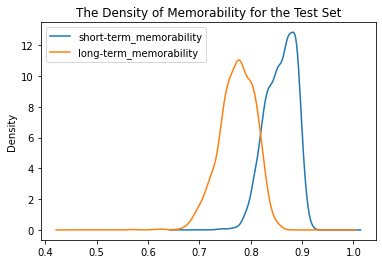

In [140]:
pred_truth[["short-term_memorability", "long-term_memorability"]].plot.kde(title="The Density of Memorability for the Test Set")

Save the results to a `.csv` file.

In [141]:
pred_truth.index.names = ["video"]
pred_truth.to_csv(test_dir.joinpath("ground-truth.csv"))